In [1]:
import numpy as np 
import pandas as pd 
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.stats
import numpy.random as rng
import matplotlib.pyplot as plt
import scipy.stats as stats

# Combine all datasets into one easy to use dataset

In [2]:
products = [
    "Hydrogen",
    "n-Butane",
    "i-Butane",
    "n-Pentane",
    "i-Pentane",
    "n-Hexane",
    "2-Mpentane",
    "3-Mpentane",
    "22-Mbutane",
    "23-Mbutane",
    "n-Heptane",
    "2-Mhexane",
    "Cyclopentane",
    "Mcyclopentan",
    "Cyclohexane",
    "Benzene",
    "Ethane",
    "Propane",
    "Methane"
]
indecies = [
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Hydrogen]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[n-Butane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[i-Butane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[n-Pentane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[i-Pentane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[n-Hexane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[2-Mpentane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[3-Mpentane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[22-Mbutane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[23-Mbutane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[n-Heptane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[2-Mhexane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Cyclopentane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Mcyclopentan]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Cyclohexane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Benzene]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Ethane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Propane]"])',
    'Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].ProductMassPercents[Methane]"])',
]
indecies_products = dict(zip(indecies, products))

In [21]:
files = glob.glob('datasets/*.xltm')

sdfs = []
for file in files:
    df = pd.read_excel(file).set_index('UniSim Excel Interface Tool')
    r1temps = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-100].FeedTemperature"])']
    r2temps = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].FeedTemperature"])']
    r1pressure = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-100].PressureDrop"])']
    r2pressure = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].PressureDrop"])']
    charge_heater = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Charge Heater].EnergyFlow"])']
    ron = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].OutletRON"])']
    pin = df.loc['Isom-100(/UnisimTag[@uopCaption="Internal EO - Elements[Isom-101].PIN"])']
    
    ix = np.array([isinstance(v, np.floating) for v in r1temps]) & ~pd.isnull(r1temps)

    sdf = df.loc[indecies, ix].copy()
    sdf.index = [indecies_products[index] for index in indecies]
    sdf = sdf.T
    sdf['r1temp'] = r1temps[ix]
    sdf['r2temp'] = r2temps[ix]
    sdf['r1pressure'] = r1pressure[ix]
    sdf['r2pressure'] = r2pressure[ix]
    sdf['charge_heater'] = charge_heater[ix]
    sdf['ron'] = ron[ix]
    sdf['pin'] = pin[ix]
    
    sdfs.append(sdf)

final_df = pd.concat(sdfs, axis=0)
final_df.to_excel('iso-dataset.xlsx', index=False)

# make sure proportions sum to 100
np.all(np.abs(np.sum(final_df[[indecies_products[index] for index in indecies]], axis=1) - 100) < 1e3)


True

# Analyze global solution

In [23]:
ix_best_ron = np.argmax(final_df['ron'])
ix_best_heater = np.argmin(final_df['charge_heater'])
ix_best_pin = np.argmax(final_df['pin'])

print("Best Ron:")
print(final_df.iloc[ix_best_ron][['ron', 'r1temp', 'r2temp', 'r1pressure', 'r2pressure', 'charge_heater']])

print("Least energy:")
print(final_df.iloc[ix_best_heater][['ron', 'r1temp', 'r2temp', 'r1pressure', 'r2pressure', 'charge_heater']])

print("Best pin:")
print(final_df.iloc[ix_best_pin][['ron', 'r1temp', 'r2temp', 'r1pressure', 'r2pressure', 'charge_heater']])

Best Ron:
ron                   83.751447
r1temp               146.000000
r2temp               146.000000
r1pressure            50.000000
r2pressure            50.000000
charge_heater    5102556.525830
Name: Unnamed: 253, dtype: object
Least energy:
ron                  83.244719
r1temp              146.000000
r2temp              128.000000
r1pressure           50.000000
r2pressure           70.000000
charge_heater   -181726.274023
Name: Unnamed: 243, dtype: object
Best pin:
ron                   83.746692
r1temp               146.000000
r2temp               144.000000
r1pressure            50.000000
r2pressure            50.000000
charge_heater    4494790.556966
Name: Unnamed: 252, dtype: object


# Fit a Neural Network to the Data

## Prepare Dataset

In [6]:
# prepare and normalize input features
Xraw = np.array(final_df[['r1temp', 'r2temp', 'r1pressure', 'r2pressure']]).astype(float)
X = scipy.stats.zscore(Xraw, axis=0)

# prepare and normalize output features
columns = [indecies_products[index] for index in indecies]
Y = np.array(final_df[columns])
Y = Y / np.sum(Y, axis=1, keepdims=True)

## Split into training/testing

In [ ]:
TEST_PERC = 0.2

n_test = int(TEST_PERC * X.shape[0])

train_ix = np.ones(X.shape[0]).astype(bool)
train_ix[rng.choice(X.shape[0], size=n_test, replace=False)] = False

Xtrain, Ytrain = X[train_ix], Y[train_ix]
Xtest, Ytest = X[~train_ix], Y[~train_ix]

## Define Model

In [ ]:
inputs = layers.Input(shape=(X.shape[1],))
hidden = layers.Dense(10, activation='tanh')(inputs)
outputs = layers.Dense(Y.shape[1], activation='softmax')(hidden)
model = keras.Model(inputs, outputs)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Nadam()
)
print(model.summary())

## Fit Model

In [ ]:
ix = rng.permutation(Xtrain.shape[0])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(Xtrain[ix,:], Ytrain[ix,:], batch_size=Xtrain.shape[0]//10, 
                    epochs=10000, validation_split=0.2, callbacks=[callback], verbose=False)

In [ ]:
print("Epochs: %d" % len(history.history['val_loss']))
test_scores = model.evaluate(Xtest, Ytest, verbose=2)
print("Test loss:", test_scores)


In [ ]:
preds = model.predict(Xtest)
Ytest_mean = np.mean(Ytest, axis=0, keepdims=True)

mse_model = np.mean(np.square(preds - Ytest), axis=0)
mse_null = np.mean(np.square(Ytest_mean - Ytest), axis=0)

ratio = mse_model / mse_null

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

columns = np.array(columns)
ix = ~np.isin(columns, ['Cyclopentane', 'Methane'])

print("Relative MSE:")
print("\n".join(['%32s %f' % c for c in zip(columns[ix], ratio[ix])]))

axes[0].bar(columns[ix], mse_model[ix])
axes[1].bar(columns[ix], mse_null[ix])
axes[2].bar(columns[ix], ratio[ix])

for i in range(3):
    axes[i].tick_params(axis='x', labelsize=26, rotation=90)
    axes[i].tick_params(axis='y', labelsize=26)

axes[0].set_ylabel('Model MSE', fontsize=32, fontweight='bold')
axes[1].set_ylabel('Null MSE', fontsize=32, fontweight='bold')
axes[2].set_ylabel('Relative MSE', fontsize=32, fontweight='bold')



# Correlations

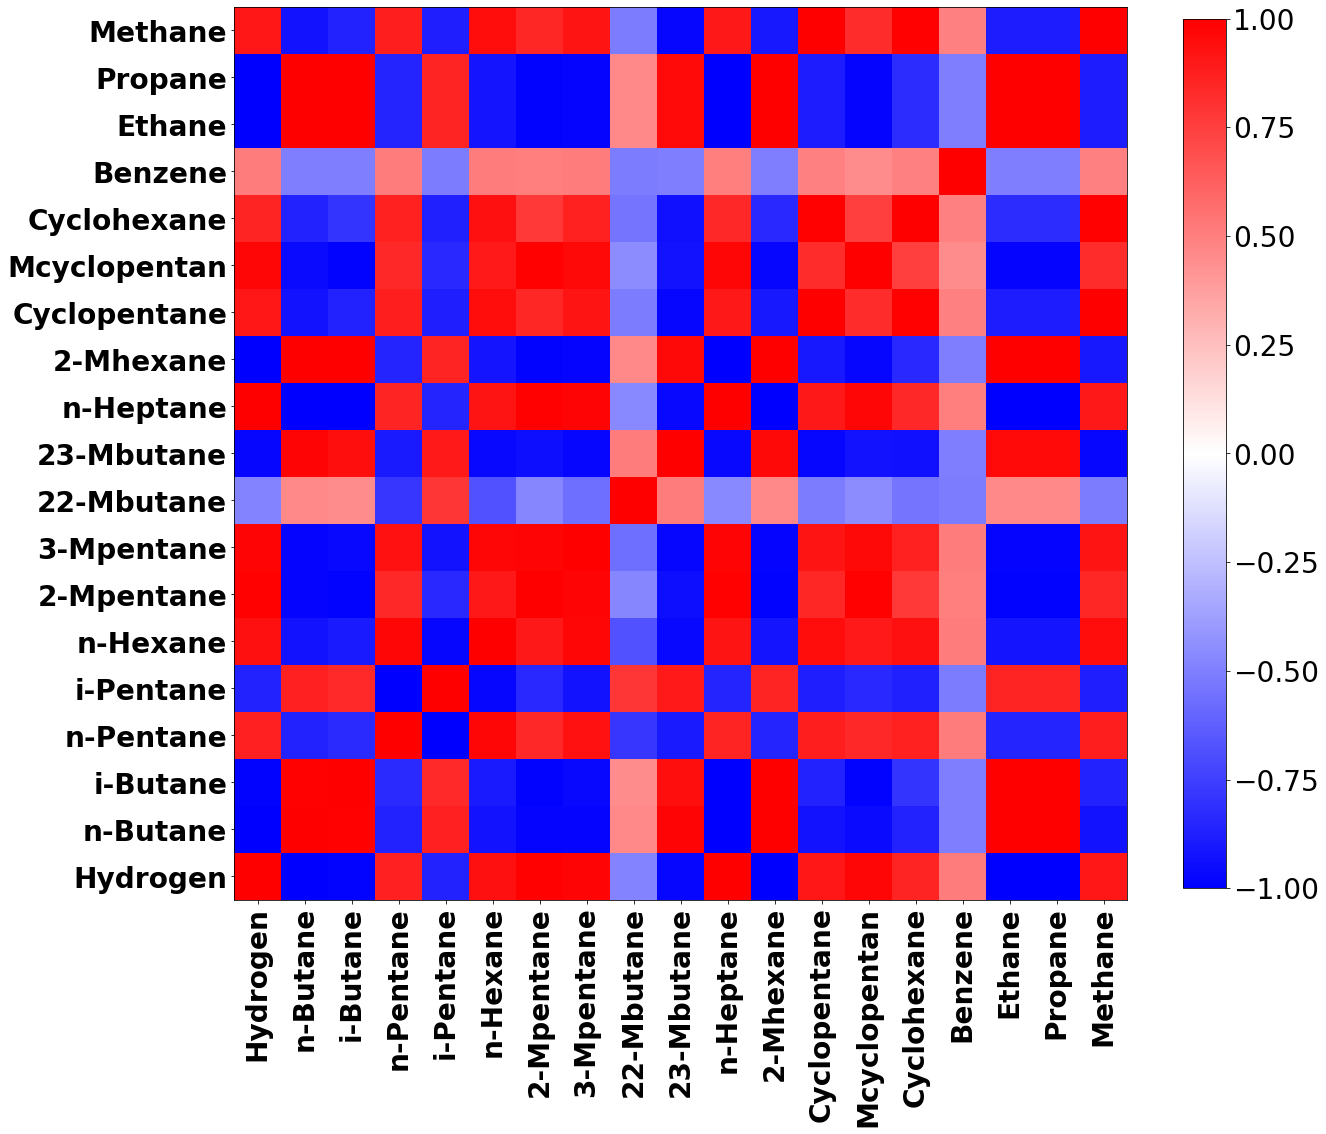

In [14]:
n = len(columns)

products = columns

corr_mat = np.zeros((n, n))
for i in range(n):
    
    col_a = np.array(final_df[products[i]])
    for j in range(i, n):
        col_b = np.array(final_df[products[j]])
        
        rho, p = stats.spearmanr(col_a, col_b)
        corr_mat[i,j] = rho
        corr_mat[j,i] = rho
    
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(corr_mat, origin='lower', cmap='bwr')
ax.set_xticks(np.arange(n))
ax.set_xticklabels(products, rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(products, fontsize=28, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28)

In [18]:
corr_df = pd.DataFrame(corr_mat, columns=products, index=products)
corr_df.to_excel('tmp/correlation_full.xlsx')